In [1]:
import tensorflow as tf
import torch

import pandas as pd

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import numpy as np

from kan import *
import time

from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import csv

from sklearn.model_selection import KFold

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression, f_regression, chi2, f_classif, mutual_info_classif
from sklearn.preprocessing import OrdinalEncoder

In [2]:
print(tf.test.is_built_with_cuda())
print(tf.config.list_physical_devices('GPU'))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
cuda


In [3]:
# read dataset
df = pd.read_csv("Dataset/lead_scoring/Leads.csv")

In [4]:
# preprocessing steps for numerical and categorical data (remove id, drop constant, replace missing value, encode, scale)
# drop id
df = df.drop(["Prospect ID", "Lead Number"], axis = 1)

# drop columns with only 1 distinct value
cat_cols = [col for col in df.select_dtypes(exclude = np.number).columns]
x = df[cat_cols].nunique()
cols_to_drop = list(x[x < 2].index)
df.drop(cols_to_drop, axis = 1, inplace = True)

# replace select to null value (later will change to Unknown)
df.replace('Select', '', inplace=True)

numeric_features = df.drop(["Converted"], axis = 1).select_dtypes(include=['int64', 'float64']).columns
categorical_features = df.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

features = preprocessor.fit_transform(df)
target = df['Converted']

In [5]:
X_train, X_temp, y_train, y_temp = train_test_split(features, target, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

train_input = torch.tensor(X_train.todense(), dtype=torch.float32).to(device)
test_input = torch.tensor(X_test.todense(), dtype=torch.float32).to(device)
val_input = torch.tensor(X_val.todense(), dtype=torch.float32).to(device)

train_label = torch.tensor(np.array(y_train).reshape(-1, 1), dtype=torch.float32).to(device)
test_label = torch.tensor(np.array(y_test).reshape(-1, 1), dtype=torch.float32).to(device)
val_label = torch.tensor(np.array(y_val).reshape(-1, 1), dtype=torch.float32).to(device)

dataset = {
    'train_input' : train_input,
    'test_input'  : test_input,
    'train_label' : train_label,
    'test_label'  : test_label,
    'val_input'   : val_input,
    'val_label'   : val_label
}

In [6]:
def train_acc():
    return torch.mean((torch.round(model(dataset['train_input'])[:,0]) == dataset['train_label'][:,0]).float())

def test_acc():
    return torch.mean((torch.round(model(dataset['test_input'])[:,0]) == dataset['test_label'][:,0]).float())

In [7]:
torch.cuda.empty_cache()

In [8]:
st = time.time()

best_model = {'grid': 50, 'k': 5, 'step': 100, 'lamb': 0, 'lamb_entropy': 0}

model = KAN(width=[dataset['train_input'].shape[1], 3, 1], grid=best_model['grid'], k=best_model['k'], device=device).to(device)
final_result = model.train(dataset, opt="LBFGS", steps=best_model['step'], lamb=best_model['lamb'], lamb_entropy=best_model['lamb_entropy'], metrics=(train_acc, test_acc), device=device)

et = time.time()

print("Accuracy", final_result['train_acc'][-1], final_result['test_acc'][-1])
print("Duration", et-st)

train loss: 1.37e-01 | test loss: 1.38e-01 | reg: 4.83e+01 : 100%|█| 100/100 [40:13<00:00, 24.14s/it

Accuracy 0.9805194735527039 0.9802131056785583
Duration 2414.165642976761


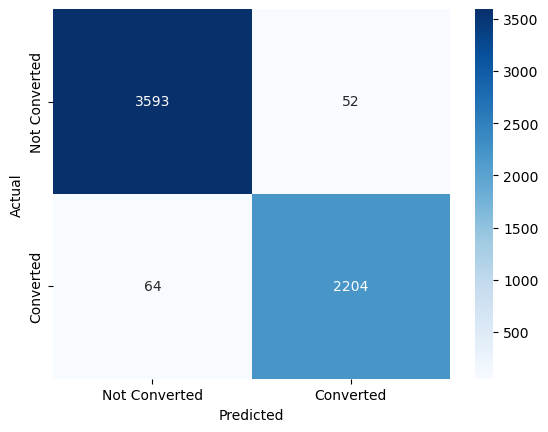

Accuracy: 0.980382208692711
Precision: 0.9769503546099291
Recall: 0.9717813051146384
F1 Score: 0.9743589743589745


In [9]:
# get predicted values
with torch.no_grad():
    test_inputs = dataset['test_input'].clone().detach().to(device)
    actual_labels = dataset['test_label'].clone().detach().to(device)
    predicted_probs = model(test_inputs)
    predicted_labels = (predicted_probs > 0.5).float()
    
y_pred = predicted_labels.cpu().numpy()
y_true = actual_labels.cpu().numpy()

conf_matrix = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

accuracy = (tn+tp)/(tn+fp+fn+tp)
precision = tp / (tp + fp) if (tp + fp) != 0 else 0
recall = tp / (tp + fn) if (tp + fn) != 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

# confusion matrix heatmap
plt.figure()
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Converted', 'Converted'], yticklabels=['Not Converted', 'Converted'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# performance metrics
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1_score}')

# save to csv
filename = "KAN_performance.csv"
with open(filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Metric", "Value"])
    writer.writerow(["Accuracy", accuracy])
    writer.writerow(["Precision", precision])
    writer.writerow(["Recall", recall])
    writer.writerow(["F1 Score", f1_score])
    writer.writerow(["Duration", et - st])

In [10]:
# cross validation
features_tensor = torch.tensor(features.todense(), dtype=torch.float32).to(device)
target_tensor = torch.tensor(target.values.reshape(-1, 1), dtype=torch.float32).to(device)

kf = KFold(n_splits=5, shuffle=True, random_state=42) # play around random_state (run 10 times)
fold = 1
train_accs = []
test_accs = []
st = time.time()

best_model = {'grid': 50, 'k': 5, 'step': 100, 'lamb': 0, 'lamb_entropy': 0}

for train_index, test_index in kf.split(features):
    print(f"Fold {fold}")
    
    X_train, X_test = features_tensor[train_index], features_tensor[test_index]
    y_train, y_test = target_tensor[train_index], target_tensor[test_index]
    
    train_input, test_input = X_train, X_test
    train_label, test_label = y_train, y_test
    
    dataset_fold = {
        'train_input': train_input,
        'train_label': train_label,
        'test_input': test_input,
        'test_label': test_label
    }
    
    model = KAN(width=[features_tensor.shape[1], 3, 1], grid=best_model['grid'], k=best_model['k'], device=device).to(device)
    final_result = model.train(dataset_fold, 
                               opt="LBFGS", 
                               steps=best_model['step'], 
                               lamb=best_model['lamb'], 
                               lamb_entropy=best_model['lamb_entropy'], 
                               metrics=(train_acc, test_acc), 
                               device=device)
    
    train_accuracy = final_result['train_acc'][-1]
    test_accuracy = final_result['test_acc'][-1]
    
    train_accs.append(train_accuracy)
    test_accs.append(test_accuracy)
    
    print(f"Train Accuracy: {train_accuracy}, Test Accuracy: {test_accuracy}")
    
    fold += 1

et = time.time()
avg_train_acc = np.mean(train_accs)
avg_test_acc = np.mean(test_accs)
print(f"Average Training Accuracy: {avg_train_acc}, Average Test Accuracy: {avg_test_acc}")
print(f"Total Time taken: {et - st} seconds")

avg_train_std = np.std(train_accs)
avg_test_std = np.std(test_accs)
print(f"Average Training std dev: {avg_train_std}, Average Test std dev: {avg_test_std}")

Fold 1


train loss: 1.43e-01 | test loss: 2.47e-01 | reg: 3.69e+01 : 100%|█| 100/100 [40:31<00:00, 24.32s/it


Train Accuracy: 0.9786255359649658, Test Accuracy: 0.9780145883560181
Fold 2


train loss: 1.55e-01 | test loss: 2.42e-01 | reg: 3.70e+01 : 100%|█| 100/100 [41:09<00:00, 24.70s/it


Train Accuracy: 0.9640151262283325, Test Accuracy: 0.9633012413978577
Fold 3


train loss: 1.42e-01 | test loss: 2.59e-01 | reg: 7.84e+01 : 100%|█| 100/100 [40:53<00:00, 24.54s/it


Train Accuracy: 0.9653679728507996, Test Accuracy: 0.964823305606842
Fold 4


train loss: 1.40e-01 | test loss: 2.37e-01 | reg: 3.89e+01 : 100%|█| 100/100 [40:33<00:00, 24.34s/it


Train Accuracy: 0.9673972129821777, Test Accuracy: 0.9685438871383667
Fold 5


train loss: 1.50e-01 | test loss: 2.53e-01 | reg: 5.01e+01 : 100%|█| 100/100 [41:28<00:00, 24.88s/it

Train Accuracy: 0.9630681872367859, Test Accuracy: 0.9633012413978577
Average Training Accuracy: 0.9676948070526123, Average Test Accuracy: 0.9675968527793884
Total Time taken: 12278.313220977783 seconds
Average Training std dev: 0.005655602816280762, Average Test std dev: 0.005550192912363921


In [11]:
# save to csv
filename = "std_dev.csv"
with open(filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Fold", "Train", "Test"])
    writer.writerow(["1", train_accs[0], test_accs[0]])
    writer.writerow(["2", train_accs[1], test_accs[1]])
    writer.writerow(["3", train_accs[2], test_accs[2]])
    writer.writerow(["4", train_accs[3], test_accs[3]])
    writer.writerow(["5", train_accs[4], test_accs[4]])
    writer.writerow(["Avg Acc", avg_train_acc, avg_test_acc])
    writer.writerow(["Avg Std Dev", avg_train_std, avg_test_std])
    writer.writerow(["Duration", et - st])

In [12]:
# feature selection
# read dataset
df = pd.read_csv("Dataset/lead_scoring/Leads.csv")

# preprocessing steps for numerical and categorical data (remove id, drop constant, replace missing value, encode, scale)
# drop id
df = df.drop(["Prospect ID", "Lead Number"], axis = 1)

# drop columns with only 1 distinct value
cat_cols = [col for col in df.select_dtypes(exclude = np.number).columns]
x = df[cat_cols].nunique()
cols_to_drop = list(x[x < 2].index)
df.drop(cols_to_drop, axis = 1, inplace = True)

# replace select to null value (later will change to Unknown)
df.replace('Select', '', inplace=True)

numeric_features = df.drop(["Converted"], axis = 1).select_dtypes(include=['int64', 'float64']).columns
categorical_features = df.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('onehot', OrdinalEncoder())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

features = preprocessor.fit_transform(df)
target = df['Converted']

features = preprocessor.fit_transform(df)
target = df['Converted']
feature_names = preprocessor.get_feature_names_out(input_features=df.columns)
features = pd.DataFrame(features, columns=feature_names)

def feature_selection(X, y, criteria, k):
    selector = SelectKBest(criteria, k=k).fit(X, y)
    selected_columns = X.columns[selector.get_support()]
    X = X[selected_columns]
    return X

new_X = feature_selection(features, target, mutual_info_classif, 10)
print("\nmutual_info_classif : \n", new_X.columns)


mutual_info_classif : 
 Index(['num__Total Time Spent on Website', 'num__Asymmetrique Activity Score',
       'cat__Lead Origin', 'cat__Last Activity',
       'cat__What is your current occupation',
       'cat__What matters most to you in choosing a course', 'cat__Tags',
       'cat__Lead Quality', 'cat__Lead Profile', 'cat__Last Notable Activity'],
      dtype='object')


In [13]:
# if use mutual_info_classif
torch.cuda.empty_cache()
new_features = df[['Total Time Spent on Website', 'Asymmetrique Activity Score', 'Lead Origin', 'Lead Source', 'Last Activity',
                   'What is your current occupation', 'Tags', 'Lead Quality', 'Lead Profile', 'Last Notable Activity']]
new_target = df['Converted']

numerical_cols = new_features.select_dtypes(exclude=['object']).columns
categorical_cols = new_features.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

new_features = preprocessor.fit_transform(new_features)

X_train, X_temp, y_train, y_temp = train_test_split(new_features, new_target, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

train_input = torch.tensor(X_train, dtype=torch.float32).to(device)
test_input = torch.tensor(X_test, dtype=torch.float32).to(device)
val_input = torch.tensor(X_val, dtype=torch.float32).to(device)

train_label = torch.tensor(np.array(y_train).reshape(-1, 1), dtype=torch.float32).to(device)
test_label = torch.tensor(np.array(y_test).reshape(-1, 1), dtype=torch.float32).to(device)
val_label = torch.tensor(np.array(y_val).reshape(-1, 1), dtype=torch.float32).to(device)

dataset = {
    'train_input' : train_input,
    'test_input'  : test_input,
    'train_label' : train_label,
    'test_label'  : test_label,
    'val_input'   : val_input,
    'val_label'   : val_label
}

st = time.time()

best_model = {'grid': 50, 'k': 5, 'step': 100, 'lamb': 0, 'lamb_entropy': 0}

model = KAN(width=[dataset['train_input'].shape[1], 3, 1], grid=best_model['grid'], k=best_model['k'], device=device).to(device)
final_result = model.train(dataset, opt="LBFGS", steps=best_model['step'], lamb=best_model['lamb'], lamb_entropy=best_model['lamb_entropy'], metrics=(train_acc, test_acc), device=device)

et = time.time()

print("Accuracy", final_result['train_acc'][-1], final_result['test_acc'][-1])
print("Duration", et-st)

train loss: 1.81e-01 | test loss: 1.79e-01 | reg: 2.07e+00 : 100%|█| 100/100 [02:49<00:00,  1.69s/it

Accuracy 0.9596861600875854 0.9605953097343445
Duration 169.3548834323883


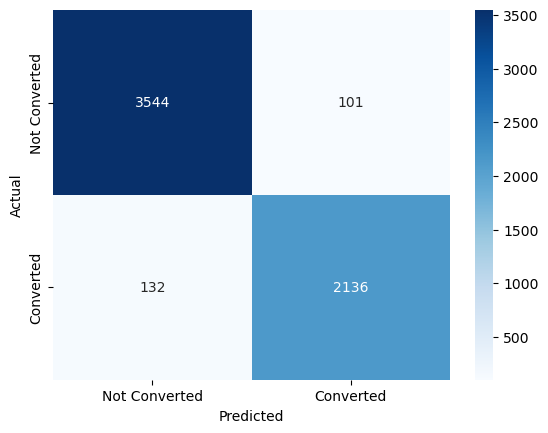

Accuracy: 0.9605952984948418
Precision: 0.9548502458649978
Recall: 0.9417989417989417
F1 Score: 0.9482796892341843


In [14]:
# get predicted values
with torch.no_grad():
    test_inputs = dataset['test_input'].clone().detach().to(device)
    actual_labels = dataset['test_label'].clone().detach().to(device)
    predicted_probs = model(test_inputs)
    predicted_labels = (predicted_probs > 0.5).float()
    
y_pred = predicted_labels.cpu().numpy()
y_true = actual_labels.cpu().numpy()

conf_matrix = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

accuracy = (tn+tp)/(tn+fp+fn+tp)
precision = tp / (tp + fp) if (tp + fp) != 0 else 0
recall = tp / (tp + fn) if (tp + fn) != 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

# confusion matrix heatmap
plt.figure()
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Converted', 'Converted'], yticklabels=['Not Converted', 'Converted'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# performance metrics
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1_score}')

# save to csv
filename = "feature_selection_performance.csv"
with open(filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Metric", "Value"])
    writer.writerow(["Accuracy", accuracy])
    writer.writerow(["Precision", precision])
    writer.writerow(["Recall", recall])
    writer.writerow(["F1 Score", f1_score])
    writer.writerow(["Duration", et - st])

In [15]:
features_tensor = torch.tensor(new_features, dtype=torch.float32).to(device)
target_tensor = torch.tensor(new_target.values.reshape(-1, 1), dtype=torch.float32).to(device)

kf = KFold(n_splits=5, shuffle=True, random_state=42) # play around random_state (run 10 times)
fold = 1
train_accs = []
test_accs = []
st = time.time()

best_model = {'grid': 50, 'k': 5, 'step': 100, 'lamb': 0, 'lamb_entropy': 0}

for train_index, test_index in kf.split(features):
    print(f"Fold {fold}")
    
    X_train, X_test = features_tensor[train_index], features_tensor[test_index]
    y_train, y_test = target_tensor[train_index], target_tensor[test_index]
    
    train_input, test_input = X_train, X_test
    train_label, test_label = y_train, y_test
    
    dataset_fold = {
        'train_input': train_input,
        'train_label': train_label,
        'test_input': test_input,
        'test_label': test_label
    }
    
    model = KAN(width=[features_tensor.shape[1], 3, 1], grid=best_model['grid'], k=best_model['k'], device=device).to(device)
    final_result = model.train(dataset_fold, 
                               opt="LBFGS", 
                               steps=best_model['step'], 
                               lamb=best_model['lamb'], 
                               lamb_entropy=best_model['lamb_entropy'], 
                               metrics=(train_acc, test_acc), 
                               device=device)
    
    train_accuracy = final_result['train_acc'][-1]
    test_accuracy = final_result['test_acc'][-1]
    
    train_accs.append(train_accuracy)
    test_accs.append(test_accuracy)
    
    print(f"Train Accuracy: {train_accuracy}, Test Accuracy: {test_accuracy}")
    
    fold += 1

et = time.time()
avg_train_acc = np.mean(train_accs)
avg_test_acc = np.mean(test_accs)
print(f"Average Training Accuracy: {avg_train_acc}, Average Test Accuracy: {avg_test_acc}")
print(f"Total Time taken: {et - st} seconds")

avg_train_std = np.std(train_accs)
avg_test_std = np.std(test_accs)
print(f"Average Training std dev: {avg_train_std}, Average Test std dev: {avg_test_std}")

Fold 1


train loss: 1.91e-01 | test loss: 2.17e-01 | reg: 2.87e+00 : 100%|█| 100/100 [02:46<00:00,  1.66s/it


Train Accuracy: 0.9529221057891846, Test Accuracy: 0.9529849886894226
Fold 2


train loss: 1.93e-01 | test loss: 1.98e-01 | reg: 3.59e+00 : 100%|█| 100/100 [02:48<00:00,  1.69s/it


Train Accuracy: 0.9535984992980957, Test Accuracy: 0.9541687965393066
Fold 3


train loss: 1.81e-01 | test loss: 2.23e-01 | reg: 3.42e+00 : 100%|█| 100/100 [02:50<00:00,  1.71s/it


Train Accuracy: 0.9533278942108154, Test Accuracy: 0.9538305997848511
Fold 4


train loss: 1.95e-01 | test loss: 2.04e-01 | reg: 1.24e+01 : 100%|█| 100/100 [02:51<00:00,  1.71s/it


Train Accuracy: 0.9522456526756287, Test Accuracy: 0.9519702792167664
Fold 5


train loss: 1.88e-01 | test loss: 2.22e-01 | reg: 7.83e+00 : 100%|█| 100/100 [02:48<00:00,  1.69s/it

Train Accuracy: 0.9530573487281799, Test Accuracy: 0.9541687965393066
Average Training Accuracy: 0.9530303001403808, Average Test Accuracy: 0.9534246921539307
Total Time taken: 845.6086323261261 seconds
Average Training std dev: 0.00045596530597413537, Average Test std dev: 0.000846262347738836


In [16]:
# save to csv
filename = "fs_std_dev.csv"
with open(filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Fold", "Train", "Test"])
    writer.writerow(["1", train_accs[0], test_accs[0]])
    writer.writerow(["2", train_accs[1], test_accs[1]])
    writer.writerow(["3", train_accs[2], test_accs[2]])
    writer.writerow(["4", train_accs[3], test_accs[3]])
    writer.writerow(["5", train_accs[4], test_accs[4]])
    writer.writerow(["Avg Acc", avg_train_acc, avg_test_acc])
    writer.writerow(["Avg Std Dev", avg_train_std, avg_test_std])
    writer.writerow(["Duration", et - st])